In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist

# Random Starting Positions

In [19]:
def random_starting_positions(n, min_dist=0.8, max_dist=1.5, seed=None):
    """
    Generate a random starting configuration for (n-1) atoms with
    atom 0 fixed at the origin.

    Parameters:
        n         : total number of atoms (including the origin)
        min_dist  : minimum pairwise distance
        max_dist  : maximum initial spread (bounding box radius)
        seed      : random seed

    Returns:
        X         : np.ndarray of shape (n-1, 3), excluding the fixed atom
    """
    if seed is not None:
        np.random.seed(seed)

    positions = []
    while len(positions) < n - 1:
        trial = np.random.uniform(-max_dist, max_dist, size=3)
        too_close = False

        # Check distance from origin and all other selected atoms
        if np.linalg.norm(trial) < min_dist:
            continue
        for p in positions:
            if np.linalg.norm(trial - p) < min_dist:
                too_close = True
                break
        if not too_close:
            positions.append(trial)

    return np.array(positions)

In [20]:
# @title Compute Energy and Gradient
def compute_energy(X):
  """
  Calculate Lennard-Jones energy for a given atom distribution
  """

  n = X.shape[0]

  # get a tensor with dim (n, n, 3) of all n possible differences x_i - x_j
  # differences[i,j,:] = X[i] - X[j]
  differences = X[:, np.newaxis, :] - X[np.newaxis, :, :]  # x_i - x_j

  # norm of each ||X[i] - X[j]|| (only care about upper/lower triangular entries not counting diagonal)
  dists = np.linalg.norm(differences, axis=2)

  # Make sure that we are not dividing by zero anywhere
  with np.errstate(divide='ignore', invalid='ignore'):
      inv_r6 = np.where(dists > 1e-6, 1.0 / dists**6, 0.0)
      inv_r12 = inv_r6**2
      pairwise_energy = inv_r12 - 2 * inv_r6

      pairwise_energy = pairwise_energy

  # Sum over i < j without double counting 
  energy = np.sum(np.triu(pairwise_energy, k=1))

  return energy

def compute_grad(X,tol=1e-10):
  """
  Computes the gradient for Lennard-Jones potential

  Parameters
  N     : the number of atoms that need to placed
  X     : the current position of the atoms
  tol   : the tolerence (lower than tolerence means zero)

  Returns
  gradX : the new gradient
  """

  gradX = np.zeros_like(X)
  n = gradX.shape[0]


  for i in range(n):

    x_i = X[i]
    gradX_i = np.zeros(3)

    for j in range(n):
      if i == j:
        continue

      r_ij = np.linalg.norm(x_i - X[j])

      if r_ij < tol:
        continue

      dV = 12*(1/(r_ij ** 8) - 1/(r_ij ** 14)) * (x_i - X[j])

      gradX_i += dV


    r_0j = np.linalg.norm(x_i)
    if r_0j >= tol:
          gradX_i += 12 * ((1 / r_0j**8) - (1 / r_0j**14)) * x_i
    gradX[i] = gradX_i


  return gradX


# Gradient Descent with Armijo

In [21]:
def backtracking_line_search(X, gradX, old_e, compute_energy=compute_energy, alpha=1.0, beta=0.5, c=1e-4):
    """
    Performs backtracking line search satisfying the Armijo condition.

    Parameters:
        X              : np.ndarray, shape (n-1, 3) — current positions excluding atom 0
        gradX          : np.ndarray, shape (n-1, 3) — gradient at X
        old_e          : float — current energy at X
        compute_energy : function taking full positions (n, 3) and returning energy
        alpha          : float — initial step size
        beta           : float — reduction factor (0 < beta < 1)
        c              : float — Armijo parameter (typically ~1e-4)

    Returns:
        alpha          : float — final step size
    """
    grad_norm_sq = np.sum(gradX**2)

    while alpha > 1e-12:
        X_new = X - alpha * gradX

        X_full = np.vstack((np.zeros((1, 3)), X_new))

        energy_new = compute_energy(X_full)

        if energy_new <= old_e - c * alpha * grad_norm_sq:
            return alpha

        alpha *= beta

    return 0.0 


def GD(N, startX=(False,None), step=1e-3, tol=1e-10, max_iter=1000, do_prints=False, history_fn = None):
  """
  Run gradient decent to find optimal atom positions for N atoms (with 1 atom fixed at (0,0,0))

  Parameters:
    N         : total number of atoms (including fixed point)
    startX    : possible predetermined starting position
    step      : the initial step size to make (before performing line search)
    tol       : the tolerence (lower than tolerence means zero)
    max_iter  : the maximum number of iterations before stopping

  Returns:
    X         : np.ndarray of shape (N, 3) with the fixed atom included (appended at the end)
  """

  n = N-1
  if startX[0]:
    X = startX[1][1:]
  else:
    X = random_starting_positions(n=N)

  gradX = np.zeros_like(X)
  prev_energy = 0

  for it in range(max_iter):

    if (do_prints):
      print(f"Starting iteration {it}")

    gradX = compute_grad(X)


    energy = compute_energy(np.vstack((np.zeros(3),X)))
    if(history_fn):
      history_fn(energy)
    grad_norm = np.linalg.norm(gradX)
    alpha = backtracking_line_search(X, gradX, prev_energy,alpha=step)

    if (do_prints):
      print(f"At iteration {it} the step size is {alpha}")
      print(f"At iteration {it} the energy of the system is {energy}")
      print(f"At iteration {it} the norm of the gradient is {grad_norm}")

    if it > 1 and abs(energy - prev_energy) / (abs(prev_energy) + 1e-8) < tol or grad_norm < tol:
      break

    prev_energy = energy
    X -= alpha * gradX

  return np.vstack((np.zeros(3),X))

# BFGS with Wolfe

In [22]:
def backtracking_line_search_quasi(
    X_free, p_free, grad_free,
    compute_energy, compute_grad,
    step=1.0, c1=1e-4, c2=0.5, max_iter=20
):
    """
    Strong-Wolfe line search over the free coordinates only.
    X_free: shape (N-1,3), p_free: shape (N-1,3), grad_free: shape (N-1,3).
    """
    def pack(Xf):
        return np.vstack((np.zeros((1,3)), Xf))

    phi0      = compute_energy(pack(X_free))
    phi0_dot  = np.sum(grad_free * p_free)

    def phi(alpha):
        Xn = X_free + alpha * p_free
        return compute_energy(pack(Xn))

    def phi_prime(alpha):
        Xn        = X_free + alpha * p_free
        grad_full = compute_grad(pack(Xn))       
        grad_f    = grad_full[1:]                 
        return np.sum(grad_f * p_free)

    alpha = step
    for _ in range(max_iter):
        val = phi(alpha)
        if val > phi0 + c1*alpha*phi0_dot:
            alpha *= 0.5
        else:
            der = phi_prime(alpha)
            if abs(der) <= c2 * abs(phi0_dot):
                return alpha
            if der > 0:
                alpha *= 0.5
            else:
                alpha *= 1.5
    return 0.0


def bfgs(N, startX=(False, None), step=1.0, tol=1e-8, max_iter=500, do_prints=False, history_fn = None):
    """
    BFGS quasi-Newton for minimizing Lennard-Jones energy of N atoms
    with atom 0 fixed at the origin.
    """
    n_free = N - 1
    nvar = 3 * n_free

    def pack(X_free):
        return np.vstack((np.zeros((1, 3)), X_free))

    if startX[0]:
        X_free = startX[1][1:].copy()
    else:
        X_free = random_starting_positions(n=N)

    grad_full = compute_grad(pack(X_free))      
    g = grad_full[1:].flatten()                 
    phi = compute_energy(pack(X_free))

    # Inverse‐Hessian approximation
    B = np.eye(nvar)

    for it in range(max_iter):
        if np.linalg.norm(g, np.inf) < tol:
            if do_prints: print(f"BFGS converged at iter {it}")
            break

        p = -B.dot(g)                           
        p_free = p.reshape((n_free, 3))      

        alpha = backtracking_line_search_quasi(
            X_free, p_free, grad_full[1:],
            compute_energy, compute_grad,
            step=step
        )
        if alpha <= 0:
            if do_prints: print("Line search failed; stopping")
            break

        s = alpha * p                          
        X_free = X_free + alpha * p_free    

        grad_full = compute_grad(pack(X_free))
        g_new = grad_full[1:].flatten()

        # BFGS update: y = g_new - g, ρ = 1/(y⋅s)
        y = g_new - g
        rho = 1.0 / np.dot(y, s)
        I = np.eye(nvar)
        B = ((I - rho * np.outer(s, y))
             .dot(B)
             .dot(I - rho * np.outer(y, s))
             + rho * np.outer(s, s))

        g = g_new
        phi = compute_energy(pack(X_free))
        if history_fn:
          history_fn(phi)
        if do_prints:
            print(f"Iter {it}: energy = {phi:.6f}, ‖g‖₋∞ = {np.linalg.norm(g, np.inf):.2e}")

    return pack(X_free)


# Plot Atoms

In [23]:
def plot_atoms(X, connect_all=True):
    """
    X: np.ndarray of shape (N, 3) with each row a 3D point
    connect_all: if True, draw lines between all pairs (i < j)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X[:,0], X[:,1], X[:,2], c='r', s=60)

    N = X.shape[0]
    for i in range(N):
        for j in range(i + 1, N):
            if connect_all:
                x_line = [X[i, 0], X[j, 0]]
                y_line = [X[i, 1], X[j, 1]]
                z_line = [X[i, 2], X[j, 2]]
                ax.plot(x_line, y_line, z_line, c='gray', linewidth=0.8)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Lennard-Jones Atom Configuration')

    plt.tight_layout()
    plt.show()


# Test

-0.02471755604433373
GD energy = -2.999999999946345
Quasi energy = -3.0


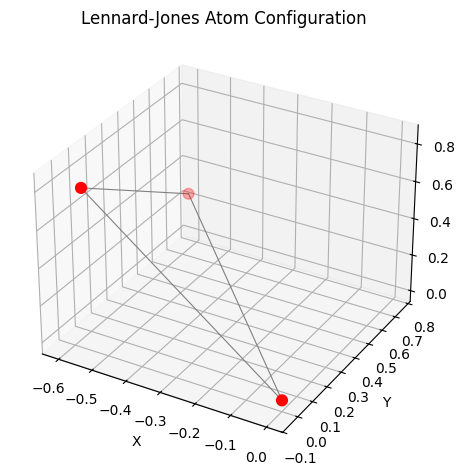

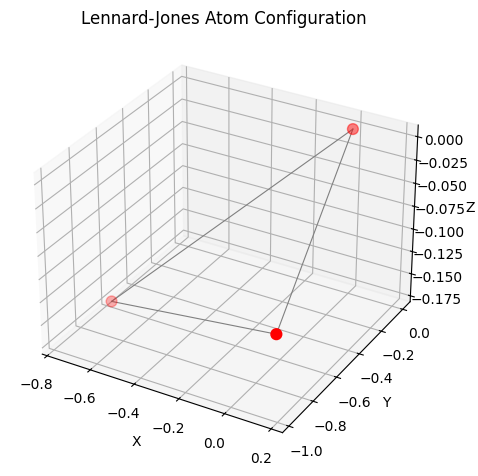

In [24]:
pos_gd = GD(2)
E_gd = compute_energy(pos_gd)
print(E_gd)
n = 3
final_pos_quasi = bfgs(n, max_iter=10000, do_prints=False)
final_pos = GD(n,step=0.01,tol=1e-10, max_iter=10000,do_prints=False)
print(f"GD energy = {compute_energy(final_pos)}")
print(f"Quasi energy = {compute_energy(final_pos_quasi)}")

plot_atoms(final_pos)
plot_atoms(final_pos_quasi)

# Convergences

-2.999999997021056


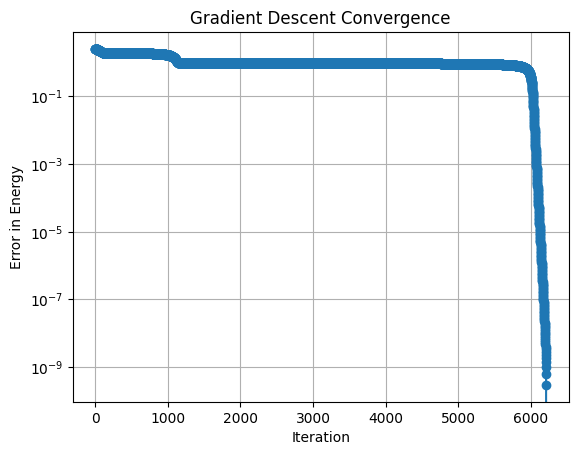

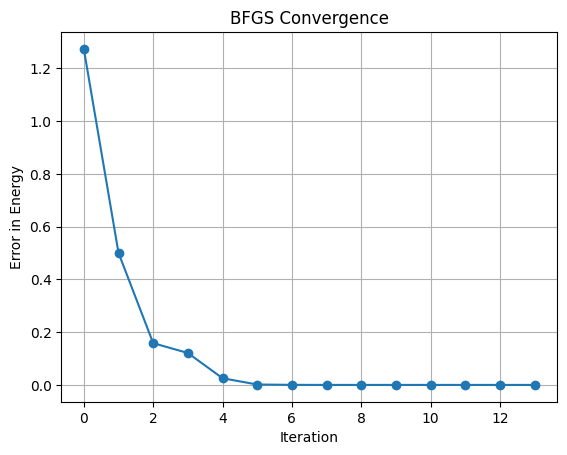

In [25]:
energy_history_gd = []
energy_history_bfgs = []

def record_energy(xk):
    energy_history_gd.append(xk)

def record_energy_bfgs(xk):
    energy_history_bfgs.append(xk)

sol_gd = GD(3, history_fn=record_energy,max_iter=10000)
print(compute_energy(sol_gd))
sol_bfgs = bfgs(3, history_fn=record_energy_bfgs,max_iter=10000)

E_star_gd   = energy_history_gd[-1]
E_star_bfgs = energy_history_bfgs[-1]

err_gd   = np.abs(np.array(energy_history_gd)   - E_star_gd)
err_bfgs = np.abs(np.array(energy_history_bfgs) - E_star_bfgs)

iters_gd   = range(len(err_gd))
iters_bfgs = range(len(err_bfgs))

plt.figure()
plt.semilogy(iters_gd, err_gd,marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Error in Energy')
plt.title('Gradient Descent Convergence')
plt.grid(True)
plt.show()


plt.figure()
plt.plot(iters_bfgs, err_bfgs, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Error in Energy')
plt.title('BFGS Convergence')
plt.grid(True)
plt.show()